# Data Augmentation 

The only goal of this notebook is to visualize what happens when we do data augmentation on the signals


After doing this data augmentation, I will need to extract features again with tsfresh... Hopefully it will work, but I think it was taking 2 days to extract.

## Imports

In [2]:
# Import required libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# Imports for the high pass signal
from scipy.signal import butter, freqz, lfilter

# KFold
from sklearn.model_selection import KFold

# Import required modules
from sklearn.preprocessing import StandardScaler

import os.path

# To write WAV File
from scipy.io.wavfile import write

# To make derivative work on multiple CPUs
from concurrent.futures import ProcessPoolExecutor
from functools import partial

import sys

# Confusion matrix
from sklearn import metrics

# 3d
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

from create_graphs import *
from transform_data import *

/home/mpgill/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Paths

In [3]:
data_type = "cis"
data_dir = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
training_or_ancillary='training_data'
path_save_accelerometer_plots = "/export/b19/mpgill/BeatPD_data_aug_plots/"

## Save in a folder cis-pd.training.combhpfnoinact for tsfresh 

In [513]:
def save_combhpfnoinact(measurement_id, path_train_data, mask_path, path_combhpfnoinact):
    df_train_data = pd.read_csv(path_train_data + measurement_id + ".csv")
    
    df_train_data = apply_mask(path_train_data, measurement_id, mask_path)
    
    # If the high_pass folder doesn't exists, we need to create it 
    if not os.path.exists(path_combhpfnoinact):
        os.makedirs(path_combhpfnoinact)
        print('The resample folder was created : ', path_combhpfnoinact)
    
    # Save to a folder 
    df_train_data.to_csv(
        path_combhpfnoinact + measurement_id + ".csv",
        index=False
    )

In [ ]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

path_train_data = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/"
mask_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/"
path_combhpfnoinact = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.combhpfnoinact/"

do_work = partial(
        save_combhpfnoinact, 
        path_train_data="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/",
        mask_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/",
        path_combhpfnoinact = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.combhpfnoinact/"
    )

num_jobs = 8
with ProcessPoolExecutor(num_jobs) as ex:
    results = list(ex.map(do_work, df_train_label['measurement_id']))

## Rotation

In [5]:
from scipy.spatial.transform import Rotation as R

def rotate_signal(measurement_id, path_train_data, params, rotation_path, mask_path=None, verbose=0):
    add_rotation = params["add_rotation"]
    min_len = params.get('min_len',1000)
    max_len = params.get('max_len',10000)
    rot_ang = params.get('rot_ang',45)
    
    temp_train_X_orig = pd.read_csv(path_train_data + measurement_id + '.csv')
    
    if verbose == 1:
        temp_train_X_orig.plot(x="Timestamp", legend=True, subplots=True, title="Before")
    
    temp_train_X = temp_train_X_orig.values[:,-3:]

    if mask_path is not None:
        print('Removing Inactivity')
        temp_train_X = apply_mask(path_train_data,
                                  measurement_id,
                                  mask_path)
        temp_train_X = temp_train_X.values[:,1:]

    sig_len = temp_train_X.shape[0]

    if add_rotation == 'True':
        print('Adding rotation')
        rot = np.random.randint(-rot_ang,rot_ang,size=1)[0]
        r = R.from_euler('xyz', [rot]*3, degrees=True)
        rot_mat = r.as_dcm()
        temp_train_X = np.dot(temp_train_X, rot_mat)
    elif add_jump_rotation == 'True':
        print('Adding Jump Rotation')
        s_ind = 0
        while (s_ind < sig_len):
            # We rotate at random increments 
            jump = np.random.randint(min_len,max_len,1)[0]

            rot = np.random.randint(-rot_ang,rot_ang,size=1)[0]
            r = R.from_euler('xyz', [rot]*3, degrees=True)
            rot_mat = r.as_dcm()
            temp_train_X[s_ind:s_ind+jump,:] = np.dot(temp_train_X[s_ind:s_ind+jump,:],rot_mat)
            s_ind = s_ind + jump

    temp_train_X = pd.concat([temp_train_X_orig.Timestamp, pd.DataFrame(temp_train_X, columns=["X","Y","Z"])], axis=1)

    if verbose == 1:
        pd.DataFrame(temp_train_X).plot(x="Timestamp", legend=True, subplots=True, title="After rotation")
    
    # If the high_pass folder doesn't exists, we need to create it 
    if not os.path.exists(rotation_path):
        os.makedirs(rotation_path)
        print('The rotate folder was created : ', rotation_path)
    
    # Save to a folder 
    temp_train_X.to_csv(
        rotation_path + measurement_id + ".csv",
        index=False
    )


### Launch Rotation for Original Data

You will have to change the value of `rotation_path` to choose the folder where to save the new data! 

In [ ]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

# Original 
do_work = partial(
        rotate_signal, 
        path_train_data="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data",
        params={'add_rotation': 'True'},
        rotation_path="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.combhpfnoinact.rotate_2/",
        mask_path=None,#"/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/",
        verbose=0,
    )

num_jobs = 8
with ProcessPoolExecutor(num_jobs) as ex:
    results = list(ex.map(do_work, df_train_label['measurement_id']))

### Launch Rotation for Comb HPF Noinact

In [12]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)
print('aaaaa')
# Original 
do_work = partial(
        rotate_signal, 
        path_train_data="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.combhpfnoinact/",
        params={'add_rotation': 'True'},
        rotation_path="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.combhpfnoinact.rotate_5/",
        mask_path=None,#"/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/",
        verbose=0,
    )

num_jobs = 8
with ProcessPoolExecutor(num_jobs) as ex:
    results = list(ex.map(do_work, df_train_label['measurement_id']))

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/
aaaaa
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotat

Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding r

Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding r

Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding rotation
Adding r

## Visualization of measurements before and after rotation

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/


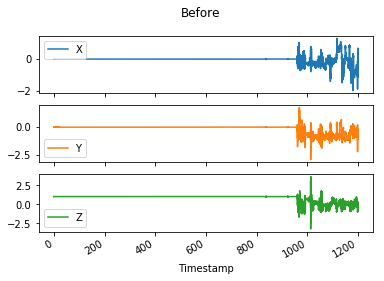

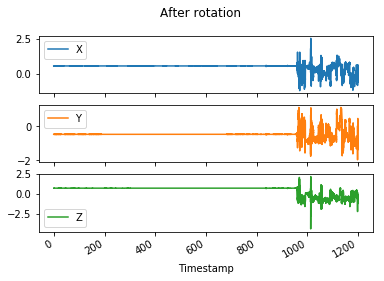

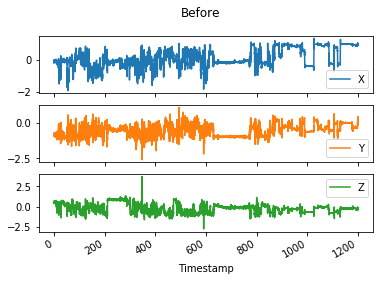

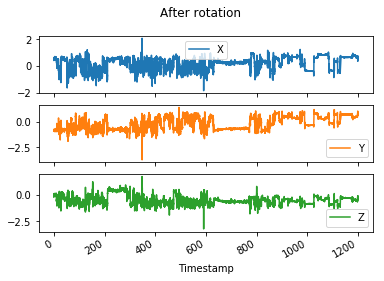

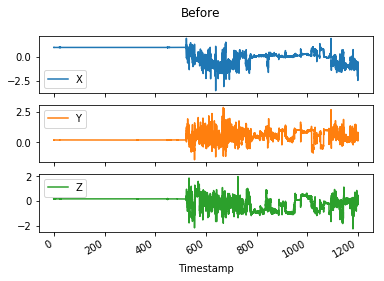

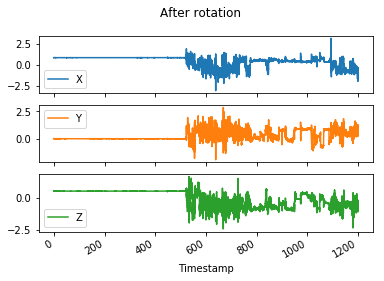

In [522]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

list_measurement_id = ["5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a"]

list_measurement_id = [
    "2d852742-10a9-4c56-9f38-779f2cd66879",
    "4fc3c295-857f-4920-8fa5-f21bfdc7ab4f",
    "db2e053a-0fb8-4206-891a-6f079fb14e3a",
]

df_train_label = interesting_patients(df_train_label=df_train_label,
                                      list_measurement_id=list_measurement_id)

load_data(measurement_id, path_train_data, params, rotation_path, factor, mask_path=None, verbose=0):
    
# df_train_data = load_data_all(df_train_label, params={'add_rotation': 'True', 'my_data_path': path_train_data})

## Stretching / Shrinking 

### Using decimate of scipy

In [361]:
import scipy.signal as sg 

path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

list_measurement_id = ["5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a"]


df_train_label = interesting_patients(df_train_label=df_train_label,
                                      list_measurement_id=list_measurement_id)

for idx in df_train_label.index:
    df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
    x = df_train_data.iloc[:,-3]
    print(df_train_data.shape)
    z = sg.decimate(x, 2, zero_phase=True)
    print((z))

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/
(59968, 4)
[ 0.00120406  0.00294356  0.00258661 ... -0.93864389 -1.03458875
 -1.01879503]
(60005, 4)
[-0.08386494 -0.10494556 -0.14283147 ...  0.97041385  0.97172821
  0.97055684]
(59847, 4)
[ 0.95742567  0.95631093  0.95703862 ... -0.63408143 -0.79537177
 -0.71673834]


### "Manual" low pass filter

In [474]:
def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq # makes cutoff between 0 and 1
#     print('normal cutoff : ', normalCutoff)
    b, a = butter(order, normalCutoff, btype='low', analog = False)
    return b, a

def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# FIXME: Not sure how to choose between filtfilt and lfilter.
# def butter_lowpass_filter(data, cutoff, fs, order):
#     normal_cutoff = cutoff / nyq
#     # Get the filter coefficients 
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     y = filtfilt(b, a, data)
#     return y

def apply_lowpass_filter(df_train_data):
    # Filter requirements.
    order = 10
    fs = 50.0  # sample rate, Hz
    cutoff = 25 * 0.9  # desired cutoff frequency of the filter, Hz 
    
    # Filter the data
    # X = [:,-3], Y = [:,-2], Z = [:,-1]
    X_filtered_data = butter_lowpass_filter(df_train_data.iloc[:,-3], cutoff, fs, order)
    Y_filtered_data = butter_lowpass_filter(df_train_data.iloc[:,-2], cutoff, fs, order)
    Z_filtered_data = butter_lowpass_filter(df_train_data.iloc[:,-1], cutoff, fs, order)

    return X_filtered_data, Y_filtered_data, Z_filtered_data

In [508]:
def resample_signal(measurement_id, path_train_data, resample_path, factor, mask_path=None, verbose=0): 
    """
    Function to stretch or shrink a signal  
    
    Keyword arguments: 
    - df_train_label: 
    - path_train_data: path to the data to load. Can provide original data or high_pass data
    - factor: use 0.90 to reduce the length of the recording of 10%. Use 1.10 to make the recording 10% longer.
    - mask_path: if provided, inactivity will be removed. 
    - verbose: default 0. If 1, plots will be printed. 
    """
    
    print("Reading " + path_train_data + measurement_id + ".csv")
    df_train_data = pd.read_csv(path_train_data + measurement_id + ".csv")
    
#         print('Y max orig: ', df_train_data.iloc[:,-2].max())
#         print('Y min orig: ', df_train_data.iloc[:,-2].min())

    if (verbose == 1) and (mask_path is not None):
        df_train_data.plot(x="Timestamp", legend=True, subplots=True, title="Before inactivity removal {0}".format(get_plot_title(idx, df_train_label)))
        plt.show()

    if mask_path is not None:
        df_train_data = apply_mask(path_train_data, measurement_id, mask_path)
#             print('Y max after inactivity removal: ', df_train_data.iloc[:,-2].max())
#             print('Y min after inactivity removal: ', df_train_data.iloc[:,-2].min())
    if factor < 1:
        X_filtered_data, Y_filtered_data, Z_filtered_data = apply_lowpass_filter(df_train_data)
    else:
        X_filtered_data = df_train_data.iloc[:,-3]
        Y_filtered_data = df_train_data.iloc[:,-2]
        Z_filtered_data = df_train_data.iloc[:,-1]

#         print('X len : ', int(len(X_filtered_data)*factor))
#         print('Y len : ', int(len(Y_filtered_data)*factor))
#         print('Z len : ', int(len(Z_filtered_data)*factor))

#         x_axis_data_type = "t" if data_type == "real" else "Timestamp"
#         time = df_train_data[x_axis_data_type]

#         df_allo =  pd.DataFrame(np.vstack([time,
#                                                 X_filtered_data,
#                                                 Y_filtered_data,
#                                                 Z_filtered_data]).T,columns= [x_axis_data_type, "X", "Y", "Z"])

#         print('AAAAAAAAAAAAAAAAAAAa')
#         df_allo.plot(x="Timestamp", legend=True, subplots=True, title="Shrink/Stretch of factor {0} on {1}".format(factor, get_plot_title(idx, df_train_label)))
#         plt.show()
#         print('bbbb')
#         print('Y max after lowpass : ', Y_filtered_data.max())
#         print('Y min after lowpass: ', Y_filtered_data.min())
    X_filtered_data = sg.resample(X_filtered_data, int(len(X_filtered_data)*factor))
    Y_filtered_data = sg.resample(Y_filtered_data, int(len(Y_filtered_data)*factor))
    Z_filtered_data = sg.resample(Z_filtered_data, int(len(Z_filtered_data)*factor))


#         print('Y max after resample: ', Y_filtered_data.max())
#         print('Y min after resample: ', Y_filtered_data.min())

    # Set the time axis. It's not the same name for the two databases
    x_axis_data_type = "t" if data_type == "real" else "Timestamp"
    time = df_train_data[x_axis_data_type]
    if factor <= 1:
        time = time[:len(X_filtered_data)]
    else:
        stop = time.iloc[len(time)-1] + ((len(X_filtered_data) - len(time)) * 0.02)
        array_time_add = np.arange(time.iloc[len(time)-1], stop, 0.02)
        if len(X_filtered_data) != (len(array_time_add) + len(time)):
            array_time_add = array_time_add[:-1]
#                 print('not equal')
#                 print('len(time) : ', len(time))
#                 print('len(array_time_add) : ', len(array_time_add))
#                 print('len(X_filtered_data) : ', len(X_filtered_data))
#             if len(X_filtered_data) % 2:
#                 array_time_add = array_time_add[:-1]
        time = time.append(pd.Series(array_time_add))

#             while len(time) != len(X_filtered_data):
#                 time = time.append(pd.Series([time.iloc[len(time)-1] + 0.02]))
#                 print(len(time))

#         print('len(time) : ', len(time))
#         print('len(X_filtered_data) : ', len(X_filtered_data))
#         print('len(Y_filtered_data) : ', len(Y_filtered_data))
#         print('len(Z_filtered_data) : ', len(Z_filtered_data))
    # Merge the dataframes together 
    df_low_pass =  pd.DataFrame(np.vstack([time,
                                            X_filtered_data,
                                            Y_filtered_data,
                                            Z_filtered_data]).T,columns= [x_axis_data_type, "X", "Y", "Z"])

    # If the high_pass folder doesn't exists, we need to create it 
    if not os.path.exists(resample_path):
        os.makedirs(resample_path)
        print('The resample folder was created : ', resample_path)
    
    # Save to a folder 
    df_low_pass.to_csv(
        resample_path + measurement_id + ".csv",
        index=False
    )

#         if verbose == 1:
#             df_train_data.plot(x="Timestamp", legend=True, subplots=True, title=get_plot_title(idx, df_train_label))
#             plt.show()

#             df_low_pass.plot(x="Timestamp", legend=True, subplots=True, title="Shrink/Stretch of factor {0} on {1}".format(factor, get_plot_title(idx, df_train_label)))
#             plt.show()

In [491]:
# def resample_signal(df_train_label, path_train_data, resample_path, factor, mask_path=None, verbose=0): 
#     """
#     Function to stretch or shrink a signal  
    
#     Keyword arguments: 
#     - df_train_label: 
#     - path_train_data: path to the data to load. Can provide original data or high_pass data
#     - factor: use 0.90 to reduce the length of the recording of 10%. Use 1.10 to make the recording 10% longer.
#     - mask_path: if provided, inactivity will be removed. 
#     - verbose: default 0. If 1, plots will be printed. 
#     """
    
#     for idx in df_train_label.index:
#         print(idx)
#         df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")

# #         print('Y max orig: ', df_train_data.iloc[:,-2].max())
# #         print('Y min orig: ', df_train_data.iloc[:,-2].min())
        
#         if (verbose == 1) and (mask_path is not None):
#             df_train_data.plot(x="Timestamp", legend=True, subplots=True, title="Before inactivity removal {0}".format(get_plot_title(idx, df_train_label)))
#             plt.show()

#         if mask_path is not None:
#             df_train_data = apply_mask(path_train_data, df_train_label["measurement_id"][idx], mask_path)
# #             print('Y max after inactivity removal: ', df_train_data.iloc[:,-2].max())
# #             print('Y min after inactivity removal: ', df_train_data.iloc[:,-2].min())
#         if factor < 1:
#             X_filtered_data, Y_filtered_data, Z_filtered_data = apply_lowpass_filter(df_train_data)
#         else:
#             X_filtered_data = df_train_data.iloc[:,-3]
#             Y_filtered_data = df_train_data.iloc[:,-2]
#             Z_filtered_data = df_train_data.iloc[:,-1]

# #         print('X len : ', int(len(X_filtered_data)*factor))
# #         print('Y len : ', int(len(Y_filtered_data)*factor))
# #         print('Z len : ', int(len(Z_filtered_data)*factor))
        
# #         x_axis_data_type = "t" if data_type == "real" else "Timestamp"
# #         time = df_train_data[x_axis_data_type]
        
# #         df_allo =  pd.DataFrame(np.vstack([time,
# #                                                 X_filtered_data,
# #                                                 Y_filtered_data,
# #                                                 Z_filtered_data]).T,columns= [x_axis_data_type, "X", "Y", "Z"])
        
# #         print('AAAAAAAAAAAAAAAAAAAa')
# #         df_allo.plot(x="Timestamp", legend=True, subplots=True, title="Shrink/Stretch of factor {0} on {1}".format(factor, get_plot_title(idx, df_train_label)))
# #         plt.show()
# #         print('bbbb')
# #         print('Y max after lowpass : ', Y_filtered_data.max())
# #         print('Y min after lowpass: ', Y_filtered_data.min())
#         X_filtered_data = sg.resample(X_filtered_data, int(len(X_filtered_data)*factor))
#         Y_filtered_data = sg.resample(Y_filtered_data, int(len(Y_filtered_data)*factor))
#         Z_filtered_data = sg.resample(Z_filtered_data, int(len(Z_filtered_data)*factor))


# #         print('Y max after resample: ', Y_filtered_data.max())
# #         print('Y min after resample: ', Y_filtered_data.min())
        
#         # Set the time axis. It's not the same name for the two databases
#         x_axis_data_type = "t" if data_type == "real" else "Timestamp"
#         time = df_train_data[x_axis_data_type]
#         if factor <= 1:
#             time = time[:len(X_filtered_data)]
#         else:
#             stop = time.iloc[len(time)-1] + ((len(X_filtered_data) - len(time)) * 0.02)
#             array_time_add = np.arange(time.iloc[len(time)-1], stop, 0.02)
#             if len(X_filtered_data) != (len(array_time_add) + len(time)):
#                 array_time_add = array_time_add[:-1]
# #                 print('not equal')
# #                 print('len(time) : ', len(time))
# #                 print('len(array_time_add) : ', len(array_time_add))
# #                 print('len(X_filtered_data) : ', len(X_filtered_data))
# #             if len(X_filtered_data) % 2:
# #                 array_time_add = array_time_add[:-1]
#             time = time.append(pd.Series(array_time_add))

# #             while len(time) != len(X_filtered_data):
# #                 time = time.append(pd.Series([time.iloc[len(time)-1] + 0.02]))
# #                 print(len(time))

# #         print('len(time) : ', len(time))
# #         print('len(X_filtered_data) : ', len(X_filtered_data))
# #         print('len(Y_filtered_data) : ', len(Y_filtered_data))
# #         print('len(Z_filtered_data) : ', len(Z_filtered_data))
#         # Merge the dataframes together 
#         df_low_pass =  pd.DataFrame(np.vstack([time,
#                                                 X_filtered_data,
#                                                 Y_filtered_data,
#                                                 Z_filtered_data]).T,columns= [x_axis_data_type, "X", "Y", "Z"])
        
#         # If the high_pass folder doesn't exists, we need to create it 
#         if not os.path.exists(resample_path):
#             os.makedirs(resample_path)
#             print('The resample folder was created : ', resample_path)

#         # Save to a folder 
#         df_low_pass.to_csv(
#             resample_path + df_train_label["measurement_id"][idx] + ".csv",
#             index=False
#         )
        
# #         if verbose == 1:
# #             df_train_data.plot(x="Timestamp", legend=True, subplots=True, title=get_plot_title(idx, df_train_label))
# #             plt.show()

# #             df_low_pass.plot(x="Timestamp", legend=True, subplots=True, title="Shrink/Stretch of factor {0} on {1}".format(factor, get_plot_title(idx, df_train_label)))
# #             plt.show()

### Generate the HPF + Inactivity Removed data augmentation: shrinking with a 0.9 factor

In [ ]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

path_train_data = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/"
mask_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/"
factor = 0.9
resample_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask.resample_{0}/".format(factor)

resample_signal(df_train_label, path_train_data, resample_path, factor, mask_path, verbose=0)

In [501]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

print(df_train_label['measurement_id'])
path_train_data = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/"
mask_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/"
factor = 1.1
resample_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask.resample_{0}/".format(factor)

# resample_signal(df_train_label, path_train_data, resample_path, factor, mask_path, verbose=0)

do_work = partial(
        resample_signal, 
        path_train_data="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/",
        resample_path="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask.resample_{0}/".format(factor),
        factor=1.1, 
        mask_path="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/",
        verbose=0,
    )

num_jobs = 8
with ProcessPoolExecutor(num_jobs) as ex:
    results = list(ex.map(do_work, df_train_label['measurement_id']))

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/
0       cc7b822c-e310-46f0-a8ea-98c95fdb67a1
1       5163afe8-a6b0-4ea4-b2ba-9b4501dd5912
2       5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a
3       fb188ae2-2173-4137-9236-19a137a402c2
4       19a3e9ea-fce1-40b7-9457-2618970beb7b
                        ...                 
1853    ab618d1f-eb27-442b-a3b7-e438fde70db1
1854    25e8bca2-051f-4216-826b-810bbddfdb2e
1855    7f7bb7b9-8656-40dd-94f9-9d546ac75722
1856    c29c2d91-c294-4655-a2a7-d4c1f456c3a2
1857    a97693fd-7024-4e68-b00a-3700306c7bc8
Name: measurement_id, Length: 1858, dtype: object
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/fb188ae2-2173-4137-9236-19a137a402c2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/cc7b822c-e310-46f0-a8ea-98c95fdb67a

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/66a44bdc-b216-4be1-90aa-d5d05f64ba01.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/dde97977-d155-4f07-8a47-6a318bd530eb.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/979c5c53-30c7-4e9c-87f0-261ea0d79ffe.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/e630e9fd-6518-43c0-9312-3254bcf9a8a0.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/12513701-85b5-4278-bd15-dafae072d599.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/c4babc3e-cf11-42c5-93e9-7c0ccb2f2507.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/a65ac7f5-e28d-4009-9cfb-05a06e8fa1a5.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ef25ea20-65f6-4cf6-9065-6fddcbd8c165.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/932197a8-dca4-4a3e-8ea6-413369bbc08d.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/3f638137-e1ef-4173-8d95-f1be574cc5c4.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/5022980a-ccea-452f-887a-c67b58c82c22.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/5f8d4735-f48b-48c4-90fe-870c17e40a8f.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/d9d41941-df97-42db-be98-50fb4304b482.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/5effef31-2e59-4626-a1a9-612513cfedbd.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/92a43430-c3b2-442e-8d60-688048bb2ea0.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/996aa23a-15a7-48d9-b511-9ff5499595b7.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/dcd5955e-3e94-40f2-818b-eda0fd33a76d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/6dc8e615-1807-4738-a131-e73e12fc3b42.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/6867bf10-f489-4c7f-abd1-06a47dd2cdd9.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/3b0ee95f-d87b-4699-b34f-74e7dc20ab01.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/02389c9e-8821-4c54-a1a7-912f0b66dd95.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b9356dbc-a3a7-4bdf-be2b-705e462f524e.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/3839d639-5418-4696-905f-56e28bc4b523.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/990b26e9-1836-4c1b-af94-4964ddabd418.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/bc89cf9a-1070-46d0-a30c-e0fbf3b39345.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/c7b82d35-63a8-429f-a038-cc6c7b5e6f4a.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8739535b-de18-4189-b458-dc906ea1eac4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/dd43a092-65bb-4c24-853a-9c0770da4a6c.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/c97b5a40-5f28-491b-a12b-e7e30fd4cd79.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/14aaada9-e4cb-47c1-92ef-4059f2201d6f.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/017b6193-e0b7-4fb9-8312-97db38f8fb28.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/d96c3ffb-5d16-482e-bd9b-91b26aa87033.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/41efbb2d-899e-41f8-8c4b-144dfab08517.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/c1f866ae-b8d6-4f9a-abbc-07e2a264e562.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/1cc72a5b-5cd0-482e-91ee-365c1d118790.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/7ec2bf09-a4a9-45e6-b2e3-296327177a7b.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b91a582c-d54d-4975-b2bd-15f2c194a4b8.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ee9656df-4384-48de-8832-9dec7a255f8d.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/38392387-d09a-40a4-afa7-9f3654066f28.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/136aa28b-6b4c-416a-bd7d-a2ba6102c301.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/5e710876-203b-4ea4-8f56-591ec1efbeab.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/38bfb614-a05c-439c-a811-7d1a96b80067.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/982ddbcc-fbe4-430d-af2e-c5b1b8074d39.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ab5287f4-8261-47ad-8ff2-22b5fe5d246e.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b7e1d247-d033-407d-82cc-9c36e81b949b.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/02b6250d-b2f6-4ea3-8e40-a37c7076b13b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.tr

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/708f35f0-4072-4f1f-a87c-cc294af34ece.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8f0510f4-f985-487f-85a1-76dce2989172.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/fec2c7d2-c800-47cf-bbe0-de2352330075.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b9b35008-2257-4200-985d-b12cb992e53c.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/475acb68-12b0-4f8d-b1f3-254777edc1d9.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/47cb7f68-2616-4238-8253-71759735444d.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/2aa1aa6e-49a6-4af7-a2ad-06d52fabae82.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/6565d879-b5b8-4bfc-898e-dc37173d1027.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/d278ca57-22e5-4adc-a18c-59ec6b89ffaf.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/f77f1cd8-d2d8-4384-aee2-1cf1db84942d.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b9236b01-f4f7-40a3-b54b-884a4b58c7cc.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/7cfd4140-fd42-49cc-a5d6-5c8e8fc8ba0a.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/93ec3e66-b237-480b-a698-c85156d38724.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ecca1868-87a1-4ee0-ba0a-acb919d47efe.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/5f816218-c118-4c2d-b869-a0ad9a31e9bf.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/97244ccd-dc2a-4b83-96f2-13788c0d041c.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/1cd13826-3b45-4867-82f9-6b2b20c1da3c.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/18cc881d-44c7-4a3a-96fa-43e963dba77e.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/0246842e-d033-4386-9044-493db45703fd.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/5775ab31-1056-45bf-8398-b620e090781f.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/69ebbae7-0752-4e1a-9d2e-0d745eb22f95.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/7b584efb-55d8-45ba-9928-397fc8240e29.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/0bb4ca2f-c554-4328-a9f0-dfebd3a92f21.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/0135a045-7978-4e4a-af98-38e645710934.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/e223c0a2-b0ab-4f58-a366-59a4db00b62c.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/cffc0ae4-2676-4e68-b4a9-68d1874c4882.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b6bb42b6-c9d4-44b5-9ac5-4f69db4228c9.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/16e83d6c-44bc-4350-b948-fd00b3845404.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/f5871446-90f6-416d-ab41-3fe178b200b9.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/252e7ed9-59c8-4e53-bd42-dbe33dce7513.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/9d09e15a-315a-47b1-a853-43807a2dc63c.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/3b8a2362-bffd-4f85-9485-84840abe31b9.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b59a04c1-a59a-4372-815f-9a3d58d4ae7d.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/f69f1fba-7ad7-4dc3-a6a9-464f2fdfc49b.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/11a14e0d-8585-429f-ade4-00506e5e4794.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/a126cc7e-a43d-4030-b453-83c3e03539a6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/6cfc9228-6c61-43e0-9642-92d5c9e886cc.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/233c43a5-df8c-4945-9dbf-0f1003786291.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/819ecf76-20b5-4a44-bd90-2bca140ef62c.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/46328c8e-ee47-434d-86e9-1ec9ee045b1b.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/69872470-ae9c-468e-9355-1e2243eb5b0d.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/2104d5e6-7650-4947-be5f-98d2e949d41f.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/988a0c37-5bc6-4789-83c3-f627a29663b7.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/10778d79-dbe4-4e33-a477-c683635080f8.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/093d3da1-c0f2-489f-a773-61ddd0b29ffe.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/4eb36634-257c-4950-852e-9c05ab451fdf.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/d3e297b9-dda4-4dab-8f5a-3c1eb626773e.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/e624a627-2d01-4e6b-b87a-aaa279769631.csv
Reading /home/sjoshi

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/3b56e771-a528-497f-b544-f84306872e68.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/bb7abe3c-93e6-45a4-a808-63162bfadd0e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/0f0afa74-8241-4cf0-bf24-b5027fc1df67.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/a46f1e55-b120-4bf8-82b1-a7e4ad7bbe34.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/0fb1fb4e-3d26-47dd-a646-f44282a7f348.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/95abf8a5-d495-440c-a482-48cd0add5b90.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8c4c8b81-9907-476b-8c79-d9095a264bc6.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/42d7487f-2bcc-4747-a1cb-c6b6db1b6f16.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/069fd3a1-dcf3-486c-823c-8edd1862facf.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/9afcf1c9-4d28-453a-930c-74854ca8e0a0.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/4de2f635-9f00-4419-bc37-2966452fd4d8.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/9a03e9ae-b953-4bbd-a795-f5cb7c1c3826.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/aab3d357-6efb-4287-ab57-ff2939656fba.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/464ac314-6c4b-4c4a-957c-28a2339150d6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.tr

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/c5230ff0-6372-4775-b074-a22d82ab1a22.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/a12438a4-11f9-4bb5-8717-f957721faec1.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/547a2ecb-38fc-4618-9122-fcbb8583e74d.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/4576dcf8-b444-4bbd-9157-8b23db3baa5b.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/a2d2a7f9-0955-4575-8696-0de072057906.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/3b243715-d79f-4461-90cc-481218b443c8.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/757536d4-5ec6-4e09-ba4e-b319169ea923.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/705ef6a2-44f0-45d0-ba01-a77dd53eb22f.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8606e0fb-9719-4ebd-b5cb-c329d889d961.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/76c6a82e-baf8-487f-9f9d-a5f5444a1873.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ec109ec3-a514-49af-a9c1-d8222d8dc685.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/0686853a-3b18-4b08-9d95-3eb04f15c950.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/cd63561b-1f72-4191-bbaa-ad0bcc830517.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/57bce91c-30c6-42f1-bc01-866f0a9e79e9.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/debdee61-f8bc-4302-b2f1-037b5573f0ea.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/7f107f1d-0547-41e3-b8bc-3ef8767a9885.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/af1e9463-68fe-4a04-b76e-9ff3645dd496.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/499b14a5-e3cb-43d2-ad4a-4c59761c922a.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/a09d16b1-018f-4140-a914-bee5a4a8d3dc.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/36d27f02-cda3-4d47-8b47-e4b8bd5dfd18.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/3b3440db-bb62-46c2-ad1d-71750ae1286a.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/c575e72a-a37b-48b5-a479-03bc0b8bd448.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ed09a8db-2f71-41d2-bbe9-6fd184ebc9ec.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/53c90b7d-6a1d-42b8-bd0a-e4b7336617fd.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/788aa60a-f33f-46fc-bafb-c27b78205f2e.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/bc339c17-0f1a-4e79-b68e-1b6884a32814.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/0e9689d7-4344-4f17-8b84-42f4b53d7ea1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/df8f969b-5f9b-49e3-9ef8-883776e3bbf1.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/d0a0e79c-2606-4f8f-b245-43a0c4ffc220.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/5d4da060-f459-4a1b-8225-ef4f3bfc0862.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/55b7c2cf-e055-4ed8-84b4-cb8bcfce19da.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/607dc849-47c9-4714-944f-1dab588f43b8.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b3b61b77-f980-4e1e-8840-10106569fde6.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8581fef3-4aee-4ef8-9b77-ea97cd5ba21e.csv
Apply_Mask function: Inactivity is being 

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/cfeb7dfa-0411-4cfb-bbfa-afd190b8ffc9.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/97dde985-6419-462b-84cf-8a0bb7c6cd81.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/6745adef-3b90-4bc0-ba5d-6a15ad32bdb8.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/14558d53-1c97-42e7-a44d-119fa43fb145.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b335ddd6-e718-41eb-a039-ce68802e7d13.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8fefded5-b48a-4699-970b-0e8a259d7250.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/40738aea-95b9-47f9-be0c-cbd880a312a9.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/f59d2b7c-c6d2-4726-a244-f33a15c8f2d5.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/0f5bc0ae-118b-4338-afd1-653fc5bbd3a3.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ae5c4a71-dd03-4c8e-b905-357b48d14f1e.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b22b56ae-1963-4374-9588-002ef43e7d45.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/1c2c091a-17ee-444e-96ce-edda2150927e.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/a37efcfc-6d2f-457c-9778-b54e0ca5fd81.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/92547cf5-442a-4248-95e7-ffe4ebd95b36.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/5293138f-343f-4500-9fcf-1ef39e314085.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8f90f2e4-76fd-453f-bdd0-c36f13e5dc39.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/dffcf070-5b39-4c57-ba0e-f8f0c6d3104c.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/1cf10288-36ba-4446-9468-4148ce759dd4.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/94200403-2a6d-4485-b005-5f60457b2a49.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/fdc7bf0b-5861-4868-b75e-52e5586364f3.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/121e09e2-4089-4446-95e9-25a5ded53c39.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/cf2a65d8-1f44-4e8d-b96c-1300935b1876.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/b3719d0b-31bc-4190-915e-2e120c95ce2e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/504215b5-0c4a-481c-8d1e-1cb94d609ad1.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/abdb15f9-b1de-40d9-a7ec-b6849497cf3a.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/6be90cb7-ce71-48f1-938d-04e6dfe6ed5a.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ee389c0c-71dd-47a9-9249-9c1bcd6c4f69.csv
Apply_Mask function: Inactivity is being 

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8390b805-6091-4f12-8d03-a853c3405ddb.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/7b9f5ce7-a152-4809-8930-c6bfaff0da8a.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/dd261c90-aab6-40c3-9da7-1b8b320c7f7a.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/a3343c78-a70d-4a84-bb0c-067ada0b065e.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/c1a5b126-c34f-4df8-8a1f-8c9fdcb445a2.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/9eac1f3c-25c3-4f72-abe0-f425df33328a.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/aa655481-7528-4119-a790-4be8b971829b.csv
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/e9e5216b-142e-46d9-a7ba-b2cc0d6e3392.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/9ee74d58-7b74-400b-8b4c-7b0be5c9a078.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/38399e75-bd22-4e76-bc93-15c919db3573.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8dceeda7-6a9d-477a-a645-f298419dc5bd.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/934b9154-6423-46f0-94c5-7acd4f5d1dff.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/9b85d886-c208-4923-8147-ae05acb769c2.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/792cb6ab-04bb-459a-9106-067186b20589.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.tr

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/8d7d848d-3de6-44f1-a332-e2cd478f51fd.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/415dba6a-d690-4790-8be1-0daded4464e1.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/e6d0a48d-4d13-4f7f-bf20-2f14aacc4fab.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/231d76f1-ced5-4e44-9dd7-5e50c110dabe.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/cc169337-66c7-46d3-baf3-309be443d6a9.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/bffbc14f-f554-4c4b-9c6d-2634da5ed12f.csv
Apply_Mask function: Inactivity is being 

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/e02bf197-07c5-4fa2-be4b-af479fff5bcf.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/7c407347-74e1-46b3-8046-5430e0d51e7c.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/7faa505d-0da1-46fb-b5c8-133c133b9529.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/9d64c5e2-3f6d-47bd-93de-5d7890bf3e90.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ed09720c-24b4-4aee-a269-8354ded537cc.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/3a34e38c-b5ea-459f-93d7-8859559f05f6.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/91a850cd-cbbc-4b19-b973-c1a28cedca2f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.tr

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/2f45936b-1f28-47c5-8aca-09ea2e1d3459.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/91fcace8-61f9-4d7e-9d2e-3fd71e3e882d.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/4b60fdd0-ad86-4e01-bb4a-ceb5f7929db9.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/82a2e8c7-cefe-4494-b79a-5ca859f4a9ad.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/16c5a776-3971-455d-a8db-6f403013aedb.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/9766bf35-a23c-4bf9-9811-9d71f9883f1a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/118bf154-6316-4e5f-8502-1e0ac2419be9.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Apply_Mask function: Inactivity is being removed.
path_train_d

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/ed7d5720-efd4-4ba8-b325-e9c5d0909a78.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/17b795e3-2138-46e4-93a4-658244678708.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/4488e001-255c-4e95-93bc-9b9969c16937.csv
Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Reading /home/sjoshi/codes/python/BeatPD/

In [509]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)
# print(path_train_data)
# # path_train_data = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/"
# mask_path = None
# factor = 0.9
# resample_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.resample_{0}/".format(factor)

# resample_signal(df_train_label, path_train_data, resample_path, factor, mask_path, verbose=0)

do_work = partial(
        resample_signal, 
        path_train_data="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/",
        resample_path="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.resample_{0}/".format(0.9),
        factor=0.9, 
        mask_path=None,
        verbose=0,
    )

num_jobs = 8
with ProcessPoolExecutor(num_jobs) as ex:
    results = list(ex.map(do_work, df_train_label['measurement_id']))

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/cc7b822c-e310-46f0-a8ea-98c95fdb67a1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/fb188ae2-2173-4137-9236-19a137a402c2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5163afe8-a6b0-4ea4-b2ba-9b4501dd5912.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/19a3e9ea-fce1-40b7-9457-2618970beb7b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e2973da8-1250-4a7c-98d5-b165570a8aeb.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0c579a72-bac5-46a2-8671-1a50620723bf.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8548d34c-4771-4ca4-bee4-d47bde435bd

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4d38808c-a2e2-40bf-9804-6cc0ad9b7383.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8340ba3e-2a36-4bcc-bf6f-bfdc852538d0.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/49202934-d5f5-4e83-8c61-c04ed0ae4a35.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/74e7102c-8a25-43e5-8f23-f0cfb6a9a58f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7259459c-3242-474e-89ad-28c4bae46b87.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/adaecec4-fb45-4fcb-8056-8f5ab6116c49.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a47b5b1d-34b1-40ae-b03e-d1c75e054d49.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1d624788-41fd-4c7d-b2c3-2fed920457f6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9312d5

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b33c911b-a09e-4937-8e17-fb242b0fa589.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5c331966-4bc0-40e9-a414-0dca02af2a50.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ce1b6de8-fa7f-4051-9549-391178456fd1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5e5fbd98-571d-4a64-86ce-59f695d24ce3.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/472201aa-effc-42a8-8f2b-11024eb5e913.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9dc1f406-5d99-492c-aba5-d5c3ed938755.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/79aca45e-ed46-4a12-829c-f98464604fbd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/92a43430-c3b2-442e-8d60-688048bb2ea0.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/996aa2

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/eea9aca1-77da-4990-b8fa-7065902c7f58.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7d759341-68cd-4e7a-a47e-32031d85081d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4195f059-861b-4785-abcd-686696bb86ac.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9e3fa515-6478-492c-8555-96a9400945e1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ca71e75c-c9aa-4d52-8570-6d9d4d405889.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7ae4f371-e804-4d36-9e90-b10edf30d1c8.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9cd72be6-3f5d-4dea-8949-e7ad74d7e8ef.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8ec48f56-7807-4636-b697-173e0deee6a4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b7d6c3

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c24d5930-a277-4780-951d-5cc26ec4ce5a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/d9e4b47b-5eb6-4887-a39e-4d1ab8be5ff6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c2e2b686-6edc-4137-a851-27f0189c6990.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/da8bad50-109e-471e-a1d7-768b30745bd4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1152d443-ea4d-467e-beca-d8a26675aaee.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/55e5c67f-bae7-4a70-b65c-64995e1bf606.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/94f30da8-525c-4a2a-93ba-044b0e99ff0d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ee24c57c-88f7-4f96-a063-05522913449e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a90bb3

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c78dd269-37a5-4ced-a236-90312926011a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8b933d47-4eaa-40f4-9391-b182d1c07b67.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/924a0da8-ca40-49e8-9e83-ac52f2ca2483.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8607390-96d5-4bb3-ab4a-60dc48382690.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/fbf5934c-abc3-46f0-b3f1-04252957f839.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/136aa28b-6b4c-416a-bd7d-a2ba6102c301.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5e710876-203b-4ea4-8f56-591ec1efbeab.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/38bfb614-a05c-439c-a811-7d1a96b80067.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4412ad

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8aa4e03-51df-4e0a-81cd-527f6d82dad3.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/aefde7e7-18f4-46a3-81d9-cfdb4137594b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ce6a3646-ea4f-48c4-86b2-e9cddc2ae0b1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f663bf31-97e8-4bdf-a297-5feb074039f9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b79aa59c-fa50-41a8-ae80-997db4e67eef.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e3f274c8-7813-4b4c-bc7f-92d703fa9153.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/13161f03-7f8b-4365-9f5d-14add153e61c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5e0e213f-2533-4929-b6b3-4af04489180c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/211a99

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/60fb3090-06d2-4a1d-a5a7-8c099a55d8f2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/93fe6ada-fffa-4725-a2a1-f30041e9e99d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c9538c25-9630-44c9-ad62-2a39c63ef6fd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f2cb291d-8c3e-4b76-9adc-6b68252b425d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c305fe91-7bd7-418e-90b9-c58f67519d8b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/60dc2ed3-5a45-4377-9bda-d2642e7acc6f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b30d2a16-b07e-4a0c-bddc-44456f2f040e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f14af6fa-d803-4b95-9ef3-17812b4cd730.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/57872a

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/fefec9ee-b5f0-495d-bab2-dd36adc00be8.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/097781af-4c3a-433e-9c64-53cad18d3db7.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/18cc881d-44c7-4a3a-96fa-43e963dba77e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0246842e-d033-4386-9044-493db45703fd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5775ab31-1056-45bf-8398-b620e090781f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/69ebbae7-0752-4e1a-9d2e-0d745eb22f95.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9ba60b2a-e041-4b2a-b0d6-d752ae920b55.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e8d8854b-257c-4266-b357-6c350d9c7bee.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/3721ff

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9dd9523b-a1c6-4163-a0ef-b464e5563d98.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/93be5ae8-0138-4364-8019-03e5c739fc3c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/60acba59-c8f7-47de-aca1-25daffc4a37c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f68f56f0-6bb5-4066-872e-acedc6c042d7.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f2e004f8-1da9-4bbf-81ae-f03ad15367cd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7c8e5e05-1e33-4e04-a605-332f821c7b4c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e3e86e38-afb6-4871-ac8f-e003b6d00ea6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8a53b48-76e8-47cb-af05-342a192fc55a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/90446d

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/083e96ba-83cc-439d-9da0-c7691f635f7b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5b51e8b2-08cc-4294-8a1f-d28f671cdf9c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8a593dc-4e6a-4499-a6aa-1041a188cd5a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b199a952-8784-4a22-b7dd-baa112784322.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/254c7d9b-37ba-4a88-809b-964da3b2dc13.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ef5b1267-c212-46c5-aab0-4f4437bc6c67.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/25e30e81-a80c-42e3-9fae-2f4c74631f60.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/53f98402-5b16-46a2-a80b-89f290ec8180.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6ed197

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/10778d79-dbe4-4e33-a477-c683635080f8.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/093d3da1-c0f2-489f-a773-61ddd0b29ffe.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4eb36634-257c-4950-852e-9c05ab451fdf.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6283ed07-b43e-4a49-8a1b-b3cf0a0ee631.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/23396fe5-31a3-4b3c-a70a-251752094f3e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/91e4fc4a-7c68-404e-afb6-485175e95d85.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7c663257-c009-439f-9440-847e21d0201d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ecee2646-44cb-4008-8cea-f97bccc2074f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a84879

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8c2d79e-811f-45b0-97c0-608db9b523cc.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c28541f6-7a89-4652-9a02-1ff4eb85fd93.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a56cd3e7-dbe0-4a6f-ad0f-4ea347752617.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0ccd45ff-7f80-4292-ab83-fc8cbf89acd9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b617fbb7-4d01-416d-aee6-dcda8ad064ad.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/bfea611b-dd6e-4611-9590-8f8ecb06fabd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/2bb9f220-ba03-4bc7-be3e-d363a09c4767.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/cfcd9110-07d2-405f-91dd-0ff66a095d81.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/975e17

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/98572f6b-a032-45cf-9347-cfc01818481e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/bea4ea13-6207-47fa-8e85-47f1161d64cd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8403256e-14ed-4912-ae80-2547fd5295a5.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0f88f775-97ce-42eb-9951-1c5160d1a14d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/04ff7116-5349-4e8e-a691-9ebf8da20c6b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/21a12e2b-be65-4de4-893b-1f1ba232b50c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/259621b8-62d3-4e99-a2e0-7f1792f63847.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f6fc2ef8-0cf8-42f7-98b1-76957ec5c9a9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4de2f6

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/757536d4-5ec6-4e09-ba4e-b319169ea923.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6d109c96-6f92-4521-806c-7f2dd88364e6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/17aaea59-7172-49e9-bff3-e07d2108baf4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/44b1cb54-f555-4480-ab41-3e7662a5f223.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6c8e1d93-24e3-453d-8bb9-449925c5f5bf.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f4409271-bf88-4cfb-a37a-00a2e3587822.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a969532e-714c-41f2-83e8-41583e41e491.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/34dacc92-8fc9-45a1-bc99-117de653292d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/755828

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e0a91889-7b65-4639-a00f-bddda3b9ffe3.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9e1083f9-d2b5-45a9-9b7b-c7d5c61801b5.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1eb42148-54d0-4244-ba0b-ab1cc279b946.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ee25f275-57b3-4886-a64f-11f54445442e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/d484940d-623a-4e6f-9a0a-f629e487625a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f55d69a1-6afe-45b9-9713-2bd4ad774d64.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/d6983199-d232-4964-8457-9a9285bd0ec9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b5fec4bd-84b6-4873-ae34-3bd6658d6173.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/63fd30

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f86b2e3e-40fa-49f2-885c-5d99aff11d0d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f3e43e5c-4699-4da3-ae5d-5562a49620ec.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/004ed441-24db-4839-8b5d-7465e4ea2a0a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c1ce054d-2fbc-4525-9310-8fbdbe7c3ce5.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/29f98ddd-d6e5-49d9-baae-be96d1b10a68.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/25f880d6-22a7-4f00-bcf9-04c17153e56c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c575e72a-a37b-48b5-a479-03bc0b8bd448.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ed09a8db-2f71-41d2-bbe9-6fd184ebc9ec.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/53c90b

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c804f492-3137-48a0-abb2-e2aaacfe6687.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/db0796c5-4a9f-4b42-ad99-a6ca2591ee5b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/12c68b6a-378d-491e-8d62-7f55c136eb91.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/14b192f9-3ddc-4a58-a401-fa68f3addabe.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5fcdffff-8b10-43f3-943a-95814f758138.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/430c735b-ae18-4b23-ab07-8cfee35b1113.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0b96fe0b-fd22-484d-b667-af1af5e68204.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/aeddf741-8744-46a7-902e-a08772f7e9ee.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5fc1c3

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/98353d12-865a-4fc2-b28a-784ea7788a79.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c4f8a395-b0b8-4926-93c6-f60d69d24ced.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/101f2d96-4763-4636-b92f-85e320a11bf5.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0e3becf3-3309-49af-8a93-f9a4f7e0933a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/106d4559-e26c-479c-84a1-3cb34a5e5127.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b277df2c-6429-4092-be15-7285a11baa1a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/aab4c3d4-0667-494a-b219-68e3bdf30a0f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/591d6b1a-58df-4f91-be4c-cf839f4e5ea7.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ac0b31

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4edfac00-9775-4bec-b50f-64505787d372.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/773ca417-4e48-4088-a384-b0e72a2c3f84.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ed101b34-10e7-4331-a9ce-c8f1f5d99ef0.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b22b56ae-1963-4374-9588-002ef43e7d45.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1c2c091a-17ee-444e-96ce-edda2150927e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a37efcfc-6d2f-457c-9778-b54e0ca5fd81.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/92547cf5-442a-4248-95e7-ffe4ebd95b36.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/cc66c552-e745-48fb-9d6b-3c6a31ea6b43.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7048cd

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/72145919-18a0-48e7-a991-4ccfca1c8631.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/84dc0f01-f9f6-4bf9-ab48-247d9bab6a62.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/450adea9-8eff-443d-a3ee-e609b16d4887.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e28a0cf0-12a3-4f76-b900-dbf397a10787.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/24538e09-5980-4600-9ef5-9d954c368218.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/88632ba1-25bb-4684-a919-f03af448041d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/47093534-52ca-41df-8115-72e3e6ed371f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/da3f8cf7-31a8-4ebf-8bde-bf6965034153.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7babfb

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/3c79c86e-c792-46c0-98d0-55f3753017fc.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b9ada852-4ff5-4ee1-8529-96a79ced0610.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5f8103c5-120d-4736-8959-f368d74acb65.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/abd3be20-bd13-49be-bd47-87821955bfb6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/88185aa3-3a84-40e4-a780-40a4cef198b4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a38bf8c5-617d-4512-8c9e-70bc9195cc06.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b1b084cd-88ab-485d-af7e-e5a6e2c73c03.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1f57b4bc-bcd5-4d65-8a2c-7acfd94afaa2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/3cd939

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/361bad1e-a5e2-4e7f-8c68-f5fa920c0c7e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e9e5216b-142e-46d9-a7ba-b2cc0d6e3392.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9ee74d58-7b74-400b-8b4c-7b0be5c9a078.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/38399e75-bd22-4e76-bc93-15c919db3573.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/22165d20-7e3d-4a11-92c5-1c4a957c6fea.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9b488196-52f9-4139-9bb1-8b71715d49ea.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/bb1f3e97-6d74-4c57-95ec-4c314bfa00a1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1fc663cc-a166-4188-823b-1dc45bc2b71a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/34056f

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/61d3f20b-f0ec-48b7-b090-43d4a9be732e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/744ae762-120a-4aa1-acd4-85f407cf880b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/dab65db3-0144-4d4c-8522-45799bb52d23.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6424733e-bd75-40e2-865f-3f3173f4fd88.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b7c199d3-4b2d-4333-89d4-0079e20dada2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e3a839dc-b254-49e5-9dbb-5e55654ccbb2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c3084532-37e0-4a03-9369-9945c25fbe1b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9861430e-70b9-4cea-a771-9b2dbf3574a9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8c0b2f

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4d9e9934-8c16-439b-934c-c0f46c0e043a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/45bd2370-4636-4ae5-92ed-e1a646fd4506.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e69dc1f1-fd24-4b8e-ab14-4b2451b74900.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4056849a-48a7-4ea1-9541-3d0e85cb14ca.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4850f715-b43c-42e0-8573-8fef65b7ee9d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/bc0cb606-9792-4089-ad4b-b4b00cf57a22.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/63b75d0f-9ba2-4c43-ba8c-642d4b5ada4c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/2986fdf2-509d-4e34-bdec-8985ed600fb6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ca489a

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9766bf35-a23c-4bf9-9811-9d71f9883f1a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/118bf154-6316-4e5f-8502-1e0ac2419be9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/cb1c7dfc-0611-4988-905f-ffcd1acf0f29.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5f50c5aa-cf7b-4a37-93a9-b32bfddd6147.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/16bc95b0-68d9-4f7f-995e-f22cf9fb907b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ca3b8a71-e986-4313-a401-c9d882509238.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ae2e31dc-3138-4c2b-a145-7dec0e860a48.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/684df7cf-8b94-430c-9af3-654fdb3805a4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/020b3f

In [511]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)
# print(path_train_data)
# # path_train_data = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/"
# mask_path = None
# factor = 1.1
# resample_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.resample_{0}/".format(factor)

# resample_signal(df_train_label, path_train_data, resample_path, factor, mask_path, verbose=0)

# list_measurement_id = ["cc7b822c-e310-46f0-a8ea-98c95fdb67a1"]

# # Filter df_train_label according to the measurement_id we are most interested in
# df_train_label = interesting_patients(df_train_label=df_train_label,
#                                       list_measurement_id=list_measurement_id)

do_work = partial(
        resample_signal, 
        path_train_data="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/",
        resample_path="/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.resample_{0}/".format(1.1),
        factor=1.1, 
        mask_path=None,
        verbose=0,
    )

num_jobs = 8
with ProcessPoolExecutor(num_jobs) as ex:
    results = list(ex.map(do_work, df_train_label['measurement_id']))

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/cc7b822c-e310-46f0-a8ea-98c95fdb67a1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0c579a72-bac5-46a2-8671-1a50620723bf.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/fb188ae2-2173-4137-9236-19a137a402c2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5163afe8-a6b0-4ea4-b2ba-9b4501dd5912.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/19a3e9ea-fce1-40b7-9457-2618970beb7b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e2973da8-1250-4a7c-98d5-b165570a8aeb.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8548d34c-4771-4ca4-bee4-d47bde435bd

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4d38808c-a2e2-40bf-9804-6cc0ad9b7383.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8340ba3e-2a36-4bcc-bf6f-bfdc852538d0.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/74e7102c-8a25-43e5-8f23-f0cfb6a9a58f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/49202934-d5f5-4e83-8c61-c04ed0ae4a35.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7259459c-3242-474e-89ad-28c4bae46b87.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/adaecec4-fb45-4fcb-8056-8f5ab6116c49.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a47b5b1d-34b1-40ae-b03e-d1c75e054d49.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1d624788-41fd-4c7d-b2c3-2fed920457f6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9312d5

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b33c911b-a09e-4937-8e17-fb242b0fa589.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5c331966-4bc0-40e9-a414-0dca02af2a50.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ce1b6de8-fa7f-4051-9549-391178456fd1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5e5fbd98-571d-4a64-86ce-59f695d24ce3.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/472201aa-effc-42a8-8f2b-11024eb5e913.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9dc1f406-5d99-492c-aba5-d5c3ed938755.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/79aca45e-ed46-4a12-829c-f98464604fbd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/92a43430-c3b2-442e-8d60-688048bb2ea0.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/996aa2

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/eea9aca1-77da-4990-b8fa-7065902c7f58.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7d759341-68cd-4e7a-a47e-32031d85081d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4195f059-861b-4785-abcd-686696bb86ac.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9e3fa515-6478-492c-8555-96a9400945e1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ca71e75c-c9aa-4d52-8570-6d9d4d405889.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7ae4f371-e804-4d36-9e90-b10edf30d1c8.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9cd72be6-3f5d-4dea-8949-e7ad74d7e8ef.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8ec48f56-7807-4636-b697-173e0deee6a4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b7d6c3

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c24d5930-a277-4780-951d-5cc26ec4ce5a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/d9e4b47b-5eb6-4887-a39e-4d1ab8be5ff6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c2e2b686-6edc-4137-a851-27f0189c6990.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/da8bad50-109e-471e-a1d7-768b30745bd4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1152d443-ea4d-467e-beca-d8a26675aaee.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/55e5c67f-bae7-4a70-b65c-64995e1bf606.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/94f30da8-525c-4a2a-93ba-044b0e99ff0d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ee24c57c-88f7-4f96-a063-05522913449e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a90bb3

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c78dd269-37a5-4ced-a236-90312926011a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8b933d47-4eaa-40f4-9391-b182d1c07b67.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/924a0da8-ca40-49e8-9e83-ac52f2ca2483.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8607390-96d5-4bb3-ab4a-60dc48382690.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/fbf5934c-abc3-46f0-b3f1-04252957f839.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/136aa28b-6b4c-416a-bd7d-a2ba6102c301.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5e710876-203b-4ea4-8f56-591ec1efbeab.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/38bfb614-a05c-439c-a811-7d1a96b80067.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4412ad

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8aa4e03-51df-4e0a-81cd-527f6d82dad3.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/aefde7e7-18f4-46a3-81d9-cfdb4137594b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ce6a3646-ea4f-48c4-86b2-e9cddc2ae0b1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f663bf31-97e8-4bdf-a297-5feb074039f9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b79aa59c-fa50-41a8-ae80-997db4e67eef.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e3f274c8-7813-4b4c-bc7f-92d703fa9153.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/13161f03-7f8b-4365-9f5d-14add153e61c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5e0e213f-2533-4929-b6b3-4af04489180c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/211a99

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/60fb3090-06d2-4a1d-a5a7-8c099a55d8f2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/93fe6ada-fffa-4725-a2a1-f30041e9e99d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c9538c25-9630-44c9-ad62-2a39c63ef6fd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f2cb291d-8c3e-4b76-9adc-6b68252b425d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c305fe91-7bd7-418e-90b9-c58f67519d8b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/60dc2ed3-5a45-4377-9bda-d2642e7acc6f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b30d2a16-b07e-4a0c-bddc-44456f2f040e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f14af6fa-d803-4b95-9ef3-17812b4cd730.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/57872a

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/fefec9ee-b5f0-495d-bab2-dd36adc00be8.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/097781af-4c3a-433e-9c64-53cad18d3db7.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/18cc881d-44c7-4a3a-96fa-43e963dba77e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0246842e-d033-4386-9044-493db45703fd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5775ab31-1056-45bf-8398-b620e090781f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/69ebbae7-0752-4e1a-9d2e-0d745eb22f95.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9ba60b2a-e041-4b2a-b0d6-d752ae920b55.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e8d8854b-257c-4266-b357-6c350d9c7bee.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/3721ff

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9dd9523b-a1c6-4163-a0ef-b464e5563d98.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/93be5ae8-0138-4364-8019-03e5c739fc3c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/60acba59-c8f7-47de-aca1-25daffc4a37c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f68f56f0-6bb5-4066-872e-acedc6c042d7.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f2e004f8-1da9-4bbf-81ae-f03ad15367cd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7c8e5e05-1e33-4e04-a605-332f821c7b4c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e3e86e38-afb6-4871-ac8f-e003b6d00ea6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8a53b48-76e8-47cb-af05-342a192fc55a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/90446d

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/083e96ba-83cc-439d-9da0-c7691f635f7b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5b51e8b2-08cc-4294-8a1f-d28f671cdf9c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8a593dc-4e6a-4499-a6aa-1041a188cd5a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b199a952-8784-4a22-b7dd-baa112784322.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/254c7d9b-37ba-4a88-809b-964da3b2dc13.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ef5b1267-c212-46c5-aab0-4f4437bc6c67.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/25e30e81-a80c-42e3-9fae-2f4c74631f60.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/53f98402-5b16-46a2-a80b-89f290ec8180.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6ed197

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/10778d79-dbe4-4e33-a477-c683635080f8.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/093d3da1-c0f2-489f-a773-61ddd0b29ffe.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4eb36634-257c-4950-852e-9c05ab451fdf.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6283ed07-b43e-4a49-8a1b-b3cf0a0ee631.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/23396fe5-31a3-4b3c-a70a-251752094f3e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/91e4fc4a-7c68-404e-afb6-485175e95d85.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7c663257-c009-439f-9440-847e21d0201d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ecee2646-44cb-4008-8cea-f97bccc2074f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a84879

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/23226d7c-ce26-434a-909c-267b95e842b5.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b8c2d79e-811f-45b0-97c0-608db9b523cc.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a56cd3e7-dbe0-4a6f-ad0f-4ea347752617.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0ccd45ff-7f80-4292-ab83-fc8cbf89acd9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b617fbb7-4d01-416d-aee6-dcda8ad064ad.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/bfea611b-dd6e-4611-9590-8f8ecb06fabd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/2bb9f220-ba03-4bc7-be3e-d363a09c4767.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/cfcd9110-07d2-405f-91dd-0ff66a095d81.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/975e17

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/98572f6b-a032-45cf-9347-cfc01818481e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/bea4ea13-6207-47fa-8e85-47f1161d64cd.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8403256e-14ed-4912-ae80-2547fd5295a5.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0f88f775-97ce-42eb-9951-1c5160d1a14d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/04ff7116-5349-4e8e-a691-9ebf8da20c6b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/21a12e2b-be65-4de4-893b-1f1ba232b50c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/259621b8-62d3-4e99-a2e0-7f1792f63847.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f6fc2ef8-0cf8-42f7-98b1-76957ec5c9a9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4de2f6

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/757536d4-5ec6-4e09-ba4e-b319169ea923.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6d109c96-6f92-4521-806c-7f2dd88364e6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/17aaea59-7172-49e9-bff3-e07d2108baf4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/44b1cb54-f555-4480-ab41-3e7662a5f223.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6c8e1d93-24e3-453d-8bb9-449925c5f5bf.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f4409271-bf88-4cfb-a37a-00a2e3587822.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a969532e-714c-41f2-83e8-41583e41e491.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/34dacc92-8fc9-45a1-bc99-117de653292d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/755828

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e0a91889-7b65-4639-a00f-bddda3b9ffe3.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9e1083f9-d2b5-45a9-9b7b-c7d5c61801b5.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1eb42148-54d0-4244-ba0b-ab1cc279b946.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ee25f275-57b3-4886-a64f-11f54445442e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/d484940d-623a-4e6f-9a0a-f629e487625a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f55d69a1-6afe-45b9-9713-2bd4ad774d64.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/d6983199-d232-4964-8457-9a9285bd0ec9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b5fec4bd-84b6-4873-ae34-3bd6658d6173.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/63fd30

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f86b2e3e-40fa-49f2-885c-5d99aff11d0d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/f3e43e5c-4699-4da3-ae5d-5562a49620ec.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/004ed441-24db-4839-8b5d-7465e4ea2a0a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c1ce054d-2fbc-4525-9310-8fbdbe7c3ce5.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/29f98ddd-d6e5-49d9-baae-be96d1b10a68.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/25f880d6-22a7-4f00-bcf9-04c17153e56c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c575e72a-a37b-48b5-a479-03bc0b8bd448.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ed09a8db-2f71-41d2-bbe9-6fd184ebc9ec.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/53c90b

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c804f492-3137-48a0-abb2-e2aaacfe6687.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/db0796c5-4a9f-4b42-ad99-a6ca2591ee5b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/12c68b6a-378d-491e-8d62-7f55c136eb91.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/14b192f9-3ddc-4a58-a401-fa68f3addabe.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5fcdffff-8b10-43f3-943a-95814f758138.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/430c735b-ae18-4b23-ab07-8cfee35b1113.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0b96fe0b-fd22-484d-b667-af1af5e68204.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/aeddf741-8744-46a7-902e-a08772f7e9ee.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5fc1c3

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/98353d12-865a-4fc2-b28a-784ea7788a79.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c4f8a395-b0b8-4926-93c6-f60d69d24ced.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/101f2d96-4763-4636-b92f-85e320a11bf5.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/0e3becf3-3309-49af-8a93-f9a4f7e0933a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/106d4559-e26c-479c-84a1-3cb34a5e5127.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b277df2c-6429-4092-be15-7285a11baa1a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/aab4c3d4-0667-494a-b219-68e3bdf30a0f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/591d6b1a-58df-4f91-be4c-cf839f4e5ea7.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ac0b31

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4edfac00-9775-4bec-b50f-64505787d372.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/773ca417-4e48-4088-a384-b0e72a2c3f84.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ed101b34-10e7-4331-a9ce-c8f1f5d99ef0.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b22b56ae-1963-4374-9588-002ef43e7d45.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1c2c091a-17ee-444e-96ce-edda2150927e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a37efcfc-6d2f-457c-9778-b54e0ca5fd81.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/92547cf5-442a-4248-95e7-ffe4ebd95b36.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/cc66c552-e745-48fb-9d6b-3c6a31ea6b43.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7048cd

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/72145919-18a0-48e7-a991-4ccfca1c8631.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/84dc0f01-f9f6-4bf9-ab48-247d9bab6a62.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/450adea9-8eff-443d-a3ee-e609b16d4887.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e28a0cf0-12a3-4f76-b900-dbf397a10787.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/24538e09-5980-4600-9ef5-9d954c368218.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/88632ba1-25bb-4684-a919-f03af448041d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/47093534-52ca-41df-8115-72e3e6ed371f.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/da3f8cf7-31a8-4ebf-8bde-bf6965034153.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/7babfb

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/3c79c86e-c792-46c0-98d0-55f3753017fc.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b9ada852-4ff5-4ee1-8529-96a79ced0610.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5f8103c5-120d-4736-8959-f368d74acb65.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/abd3be20-bd13-49be-bd47-87821955bfb6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/88185aa3-3a84-40e4-a780-40a4cef198b4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/a38bf8c5-617d-4512-8c9e-70bc9195cc06.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b1b084cd-88ab-485d-af7e-e5a6e2c73c03.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1f57b4bc-bcd5-4d65-8a2c-7acfd94afaa2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/3cd939

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/361bad1e-a5e2-4e7f-8c68-f5fa920c0c7e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e9e5216b-142e-46d9-a7ba-b2cc0d6e3392.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9ee74d58-7b74-400b-8b4c-7b0be5c9a078.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/38399e75-bd22-4e76-bc93-15c919db3573.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/22165d20-7e3d-4a11-92c5-1c4a957c6fea.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9b488196-52f9-4139-9bb1-8b71715d49ea.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/bb1f3e97-6d74-4c57-95ec-4c314bfa00a1.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/1fc663cc-a166-4188-823b-1dc45bc2b71a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/34056f

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/61d3f20b-f0ec-48b7-b090-43d4a9be732e.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/744ae762-120a-4aa1-acd4-85f407cf880b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/dab65db3-0144-4d4c-8522-45799bb52d23.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/6424733e-bd75-40e2-865f-3f3173f4fd88.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/b7c199d3-4b2d-4333-89d4-0079e20dada2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e3a839dc-b254-49e5-9dbb-5e55654ccbb2.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/c3084532-37e0-4a03-9369-9945c25fbe1b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9861430e-70b9-4cea-a771-9b2dbf3574a9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/8c0b2f

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4d9e9934-8c16-439b-934c-c0f46c0e043a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/45bd2370-4636-4ae5-92ed-e1a646fd4506.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/e69dc1f1-fd24-4b8e-ab14-4b2451b74900.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4056849a-48a7-4ea1-9541-3d0e85cb14ca.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/4850f715-b43c-42e0-8573-8fef65b7ee9d.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/bc0cb606-9792-4089-ad4b-b4b00cf57a22.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/63b75d0f-9ba2-4c43-ba8c-642d4b5ada4c.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/2986fdf2-509d-4e34-bdec-8985ed600fb6.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ca489a

Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/9766bf35-a23c-4bf9-9811-9d71f9883f1a.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/118bf154-6316-4e5f-8502-1e0ac2419be9.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/cb1c7dfc-0611-4988-905f-ffcd1acf0f29.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/5f50c5aa-cf7b-4a37-93a9-b32bfddd6147.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/16bc95b0-68d9-4f7f-995e-f22cf9fb907b.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ca3b8a71-e986-4313-a401-c9d882509238.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/ae2e31dc-3138-4c2b-a145-7dec0e860a48.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/684df7cf-8b94-430c-9af3-654fdb3805a4.csv
Reading /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/020b3f

### Playing around with stretching/shrinking on specific measurements 

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/
Y max orig:  3.8846907552559817
Y min orig:  -5.209948161622823


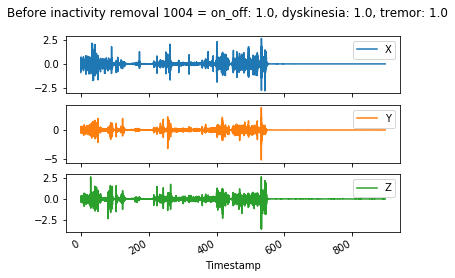

Apply_Mask function: Inactivity is being removed.
path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/
Y max after inactivity removal:  3.8846907552559817
Y min after inactivity removal:  -5.209948161622823
normal cutoff :  0.9
normal cutoff :  0.9
normal cutoff :  0.9
X len :  24703
Y len :  24703
Z len :  24703
AAAAAAAAAAAAAAAAAAAa


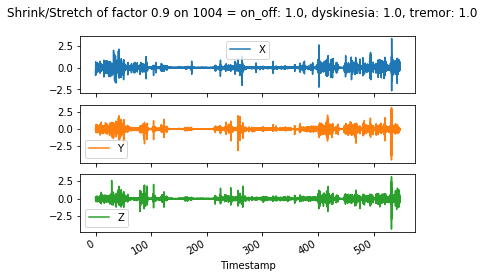

bbbb
Y max after lowpass :  3.0922805965184583
Y min after lowpass:  -4.481045463689932
Y max after resample:  3.0956487210941006
Y min after resample:  -4.581522605552528


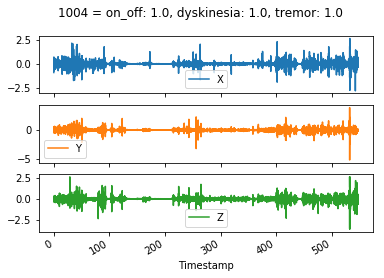

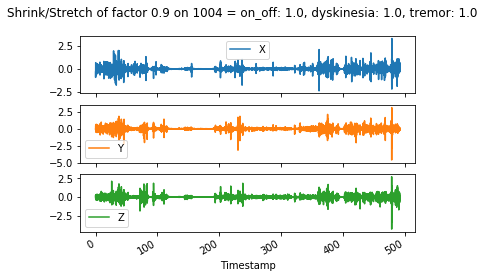

In [469]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

list_measurement_id = ["5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a"]


list_measurement_id = [
    "2d852742-10a9-4c56-9f38-779f2cd66879",
    "4fc3c295-857f-4920-8fa5-f21bfdc7ab4f",
    "db2e053a-0fb8-4206-891a-6f079fb14e3a",
]

list_measurement_id = [
#     "5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a",
    "cc7b822c-e310-46f0-a8ea-98c95fdb67a1",
#     "5163afe8-a6b0-4ea4-b2ba-9b4501dd5912",
#     "db2e053a-0fb8-4206-891a-6f079fb14e3a",
#     "2d852742-10a9-4c56-9f38-779f2cd66879",
#     "2e3a4c9c-ff01-4a28-bfcf-ce9b7633a39d",  # no inactivity should be removed
#     "3cf49c01-0499-4bad-9167-67691711204a",  # no inactivity should be removed PAS LA??
#     "3d0f965c-9d72-43d1-9369-1ea3acf963cc",  # PAS LA ???
#     "4b269cc2-8f0c-4816-adbf-10c0069b8833",
#     "4bc51b90-bfce-4231-85e1-5de3b4bc0745",
#     "4fc3c295-857f-4920-8fa5-f21bfdc7ab4f",
]  # bit of inactivity in the middle]

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label,
                                      list_measurement_id=list_measurement_id)

# path_train_data = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data"
path_train_data = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/"
mask_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/"
factor = 0.9
resample_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask.resample_{0}".format(factor)

resample_signal(df_train_label, path_train_data, resample_path, factor, mask_path, verbose=1)


In [454]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))



### Time domain to frequency + Plot

Source: https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html

0       -0.891914
1       -0.678871
2       -0.267405
3       -0.016573
4        0.135651
           ...   
44935   -0.000259
44936   -0.000198
44937    0.000245
44938    0.000114
44939    0.000002
Name: X, Length: 44940, dtype: float64
44940


(-5, 110)

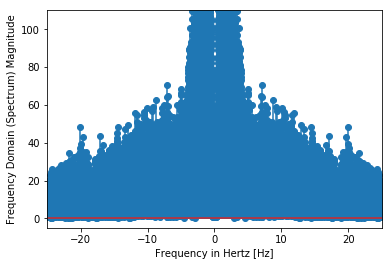

In [435]:
from scipy import fftpack

df_train_data = pd.read_csv(path_train_data + "cc7b822c-e310-46f0-a8ea-98c95fdb67a1" + ".csv")
x = df_train_data.iloc[:,-3]
f_s = 50
X = fftpack.fft(df_train_data.iloc[:,-3])
print(df_train_data.iloc[:,-3])

freqs = fftpack.fftfreq(len(x)) * f_s
print(len(freqs))
fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
ax.set_ylim(-5, 110)

allDone()

### Stretching Visualization

In [ ]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

list_measurement_id = ["5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a"]


# list_measurement_id = [
#     "2d852742-10a9-4c56-9f38-779f2cd66879",
#     "4fc3c295-857f-4920-8fa5-f21bfdc7ab4f",
#     "db2e053a-0fb8-4206-891a-6f079fb14e3a",
# ]

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label,
                                      list_measurement_id=list_measurement_id)

plot_accelerometer(df_train_label=df_train_label,
                   data_type=data_type,
                   path_train_data=path_train_data,
                   path_accelerometer_plots=path_save_accelerometer_plots)


for idx in df_train_label.index:
    #y = librosa.core.resample(x, 4000, 16000)
    df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
    
    display(df_train_data)
    
    df_train_data["Timestamp"] = pd.to_datetime(df_train_data["Timestamp"], unit='s')
    display(df_train_data)
    df_train_data = df_train_data.set_index(df_train_data.Timestamp)
    print(type(df_train_data["Timestamp"]))
    #df_train_data_minute = df_train_data.resample('S').sum()
    df_train_data_minute = df_train_data.resample('S').mean()
    display(df_train_data_minute)
    
    df_train_data_minute.index = np.arange(0,len(df_train_data_minute))
    df_train_data_minute.plot(subplots=True)#(x="Timestamp", legend=True, subplots=True, title="Noise added")
    plt.show()
    

In [158]:
df_train_data_minute.iloc[:,-2:]

,Y,Z
Timestamp,,
1970-01-01 00:00:00,41.161621,-17.199219
1970-01-01 00:00:01,40.248535,-16.864990
1970-01-01 00:00:02,40.341553,-16.849121
1970-01-01 00:00:03,40.242676,-16.827881
1970-01-01 00:00:04,40.049316,-16.837646
...,...,...
1970-01-01 00:19:55,-1.395996,-6.104492
1970-01-01 00:19:56,-1.392090,-6.095215
1970-01-01 00:19:57,-1.392578,-6.094238


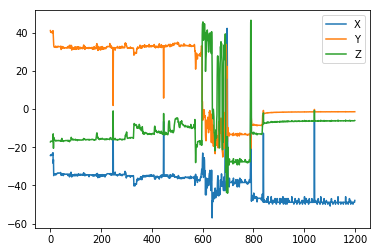

In [161]:
df = pd.DataFrame(np.arange(0,1200))
df_train_data_minute.index = np.arange(0,1200)
df_train_data_minute
df_train_data_minute.plot()#(x="Timestamp", legend=True, subplots=True, title="Noise added")
plt.show()

## Add noise 

* Does adding noise also act as an offset removal? 
  * I guess it adds a noise centered at 0 so it kind of does 
  
We also have two new hyperparameters here:
* `mu` (mean) : Centre of the distribution
* `sigma` (variance) : Strandard deviation (spread, or width or the distribution)


Sources:
* https://stackoverflow.com/questions/46093073/adding-gaussian-noise-to-a-dataset-of-floating-points-and-save-it-python 

In [173]:
def add_noise(df_train_label, noise_path, path_train_data, data_type, mask_path=None):
    """
    TODO
    
    Keyword Arguments:
    - mask_path: Provide if you want to remove inactivity 
    """
    
    # Create noise 
    mu, sigma = 0, 0.1

    for idx in df_train_label.index:
        print(df_train_label["measurement_id"][idx])
        df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        
        if mask_path is not None:
            df_train_data = apply_mask(path_train_data, df_train_label["measurement_id"][idx], mask_path)
        # creating a noise with the same dimension as the recording
        df_noise = np.random.normal(mu, sigma, df_train_data.iloc[:,-3:].shape)#[59805,3]) 

        df_signal = df_train_data.iloc[:,-3:] + df_noise
        df_signal = pd.concat([df_train_data.iloc[:, 0], df_signal], axis=1)

        # If the high_pass folder doesn't exists, we need to create it 
        if not os.path.exists(noise_path):
            os.makedirs(noise_path)
            print('The noise folder was created : ', noise_path)

        # Save to a folder 
        df_signal.to_csv(
            noise_path + df_train_label["measurement_id"][idx] + ".csv",
            index=False
        )

### Create noise augmented csv files for the recodings (on original data)

In [ ]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

noise_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.noise_mu_0_sig_0.1/"
data_type = "cis"

add_noise(df_train_label, noise_path, path_train_data, data_type)

### Create noise augmented csv files for the recodings (on high pass filtered + inactivity removed data)

In [ ]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

# Redefine manually the path because we want the data where high pass was already applied
path_train_data = '/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/'
mask_path = '/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/'
noise_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.combhpfnoinact.noise_mu_0_sig_0.1/"
data_type = "cis"

add_noise(df_train_label, noise_path, path_train_data, data_type, mask_path)

### This measurement didn't have any high pass for some reason 

In [179]:
data_type = "cis"
path_train_data, df_train_label = define_data_type(data_type, data_dir, 'training_data')

list_measurement_id = ["dc90dc36-b4e5-43ec-b3e8-47c39c763c71"]
high_pass_path = '/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/'

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)
print(df_train_label)

high_pass_filter(df_train_label, high_pass_path, path_train_data, data_type)

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/
                          measurement_id  subject_id  on_off  dyskinesia  \
11  dc90dc36-b4e5-43ec-b3e8-47c39c763c71        1004     1.0         1.0   

    tremor  
11     1.0  
Working on  dc90dc36-b4e5-43ec-b3e8-47c39c763c71


### Added noise visualization

path_train_data :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data/
measurement_id :  2d852742-10a9-4c56-9f38-779f2cd66879


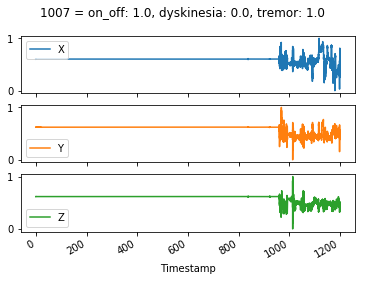

measurement_id :  4fc3c295-857f-4920-8fa5-f21bfdc7ab4f


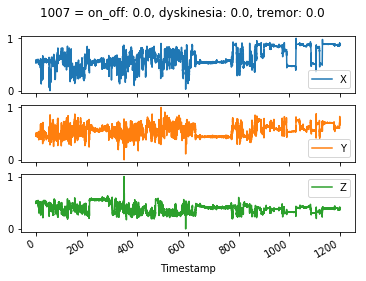

measurement_id :  db2e053a-0fb8-4206-891a-6f079fb14e3a


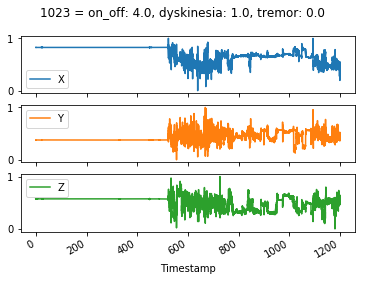

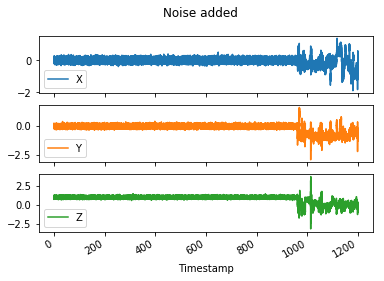

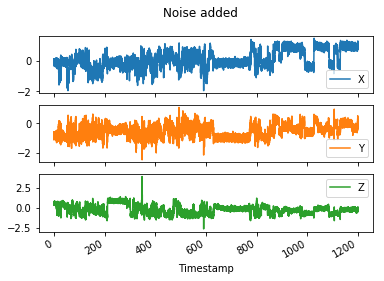

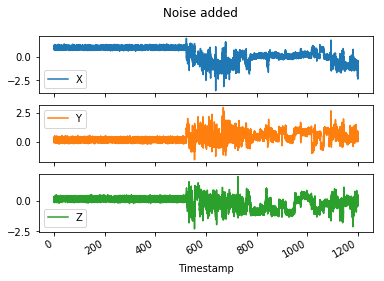

In [91]:
path_train_data, df_train_label = define_data_type(data_type,
                                                   data_dir,
                                                   training_or_ancillary)

list_measurement_id = ["5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a"]


list_measurement_id = [
    "2d852742-10a9-4c56-9f38-779f2cd66879",
    "4fc3c295-857f-4920-8fa5-f21bfdc7ab4f",
    "db2e053a-0fb8-4206-891a-6f079fb14e3a",
]

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label,
                                      list_measurement_id=list_measurement_id)

plot_accelerometer(df_train_label=df_train_label,
                   data_type=data_type,
                   path_train_data=path_train_data,
                   path_accelerometer_plots=path_save_accelerometer_plots)


for idx in df_train_label.index:
    df_train_data = pd.read_csv(noise_path + df_train_label["measurement_id"][idx] + ".csv")

    df_train_data.plot(x="Timestamp", legend=True, subplots=True, title="Noise added")
    plt.show()
    
#     # signal to pyplot that we want 3d plots
#     fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})

#     # convenience wrapper for plotting function
#     def plot_3d(df):
#         ax.scatter(df.X, df.Y.astype(float), df.Z) # dims must be floats

#     # reshape with melt(), then plot
#     plot_3d(df_signal)
# #     plot_3d(pd.melt(test5, id_vars='x', var_name='y', value_name='z'))
# #     plot_3d(pd.melt(test6, id_vars='x', var_name='y', value_name='z'))

#     # label axes
#     ax.set_xlabel('x', fontsize=20)
#     ax.set_ylabel('y', fontsize=20)
#     ax.set_zlabel('z', fontsize=20)

#     # optional view configurations
#     ax.elev = 10
#     ax.axim = 20
    


In [63]:
salut = pd.DataFrame([[1,2,3],[14,15,16],[57,38,9]], columns=['X','Y','Z'])

In [64]:
salut

,X,Y,Z
0,1,2,3
1,14,15,16
2,57,38,9


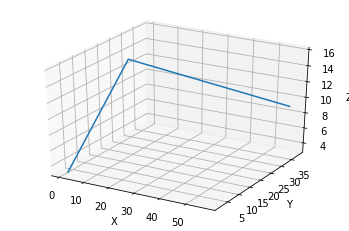

In [65]:
threedee = plt.figure().gca(projection='3d')
threedee.plot(salut.X, salut.Y, salut.Z)
threedee.set_xlabel('X')
threedee.set_ylabel('Y')
threedee.set_zlabel('Z')
plt.show()

# Drafts

### Example on how to do rotation on only one measurement 

In [ ]:
# print(df_train_label['measurement_id'])
# path_train_data = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass/"
# mask_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/"
# factor = 1.1
# resample_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask.resample_{0}/".format(factor)


# rotate_signal(measurement_id, path_train_data, params, rotation_path, factor, mask_path=None, verbose=0):


### Example of how Rotation was done in the LSTM 

In [521]:
# from scipy.spatial.transform import Rotation as R

# def load_data(df_train_label, idx, params):
#     path_train_data = params["my_data_path"]
#     remove_inactivity = False
#     add_rotation = params["add_rotation"]
#     min_len = params.get('min_len',1000)
#     max_len = params.get('max_len',10000)
#     rot_ang = params.get('rot_ang',45)
    
#     temp_train_X_orig = pd.read_csv(path_train_data+df_train_label["measurement_id"][idx] + '.csv')
    
#     temp_train_X_orig.plot(x="Timestamp", legend=True, subplots=True, title="Before")
    
#     temp_train_X = temp_train_X_orig.values[:,-3:]

#     if remove_inactivity == 'True':
#         temp_train_X = apply_mask(path_train_data,
#                                   df_train_label["measurement_id"][idx],
#                                   mask_path)
#         temp_train_X = temp_train_X.values[:,1:]

#     sig_len = temp_train_X.shape[0]

#     if add_rotation == 'True':
#         rot = np.random.randint(-rot_ang,rot_ang,size=1)[0]
#         r = R.from_euler('xyz', [rot]*3, degrees=True)
#         rot_mat = r.as_dcm()
#         temp_train_X = np.dot(temp_train_X, rot_mat)
#     elif add_jump_rotation == 'True':
#         s_ind = 0
#         while (s_ind < sig_len):
#             # We rotate at random increments 
#             jump = np.random.randint(min_len,max_len,1)[0]

#             rot = np.random.randint(-rot_ang,rot_ang,size=1)[0]
#             r = R.from_euler('xyz', [rot]*3, degrees=True)
#             rot_mat = r.as_dcm()
#             temp_train_X[s_ind:s_ind+jump,:] = np.dot(temp_train_X[s_ind:s_ind+jump,:],rot_mat)
#             s_ind = s_ind + jump

#     temp_train_X = pd.concat([temp_train_X_orig.Timestamp, pd.DataFrame(temp_train_X, columns=["X","Y","Z"])], axis=1)
# #     display(temp_train_X)
# #     pd.DataFrame(temp_train_X).plot(x="Timestamp", legend=True, subplots=True, title="After rotation")
    
    
# #     num_frames = int(np.ceil(float(np.abs(sig_len - frame_length)) / frame_step))
# #     pad_sig_len = num_frames * frame_step + frame_length
# #     temp_pad = np.zeros((pad_sig_len - sig_len,3))
# #     pad_sig = np.concatenate((temp_train_X, temp_pad),axis=0)
# #     indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
#     #temp_train_X = np.expand_dims(temp_train_X,axis=0)
# #     temp_train_X = temp_train_X[indices,:]
# #     temp_train_X = temp_train_X.reshape(temp_train_X.shape[0],-1)
    
# def load_data_all(data_frame_in, params):
#     train_X = []
#     for idx in data_frame_in.index:
# #         print(idx)
#         temp_X = load_data(data_frame_in, idx, params)
#         train_X.append(temp_X)
#     train_X = np.vstack(train_X)
#     return train_X